In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSVs into DataFrame using day as index
df1 = pd.read_csv('data1.csv', index_col=0)
df2 = pd.read_csv('data2.csv', index_col=0)
df3 = pd.read_csv('data3.csv', index_col=0)
df4 = pd.read_csv('data4.csv', index_col=0)
df5 = pd.read_csv('data5.csv', index_col=0)
df6 = pd.read_csv('data6.csv', index_col=0)
df7 = pd.read_csv('data7.csv', index_col=0)
df8 = pd.read_csv('data8.csv', index_col=0)
df9 = pd.read_csv('data9.csv', index_col=0)

# Concatenate DataFrames on horizontal axis
merged_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9], axis=1)
merged_df.index.name = 'day'
merged_df.columns = [f'price_{i}' for i in range(1,10)]

display(merged_df)


,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,price_9
day,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.003624,1.007120,0.994078,1.004702,1.007134,1.002788,0.997375,0.984437,1.005241
3,1.002124,1.022053,0.999445,1.001450,1.006194,1.024929,1.009087,0.975334,1.022550
4,1.010399,1.017504,0.989566,0.980873,0.986844,1.030910,1.024263,0.974543,1.007663
5,1.017414,1.013733,0.978766,0.974627,0.990560,1.022618,1.018822,0.995599,1.011878
...,...,...,...,...,...,...,...,...,...
4995,2.017841,1.706049,1.943758,1.553464,1.344542,1.080591,1.756785,1.607051,1.380855
4996,2.034828,1.694777,1.941728,1.556080,1.350560,1.083741,1.746160,1.602931,1.381030
4997,2.046600,1.674699,1.939112,1.557985,1.355961,1.074442,1.738298,1.594615,1.384002


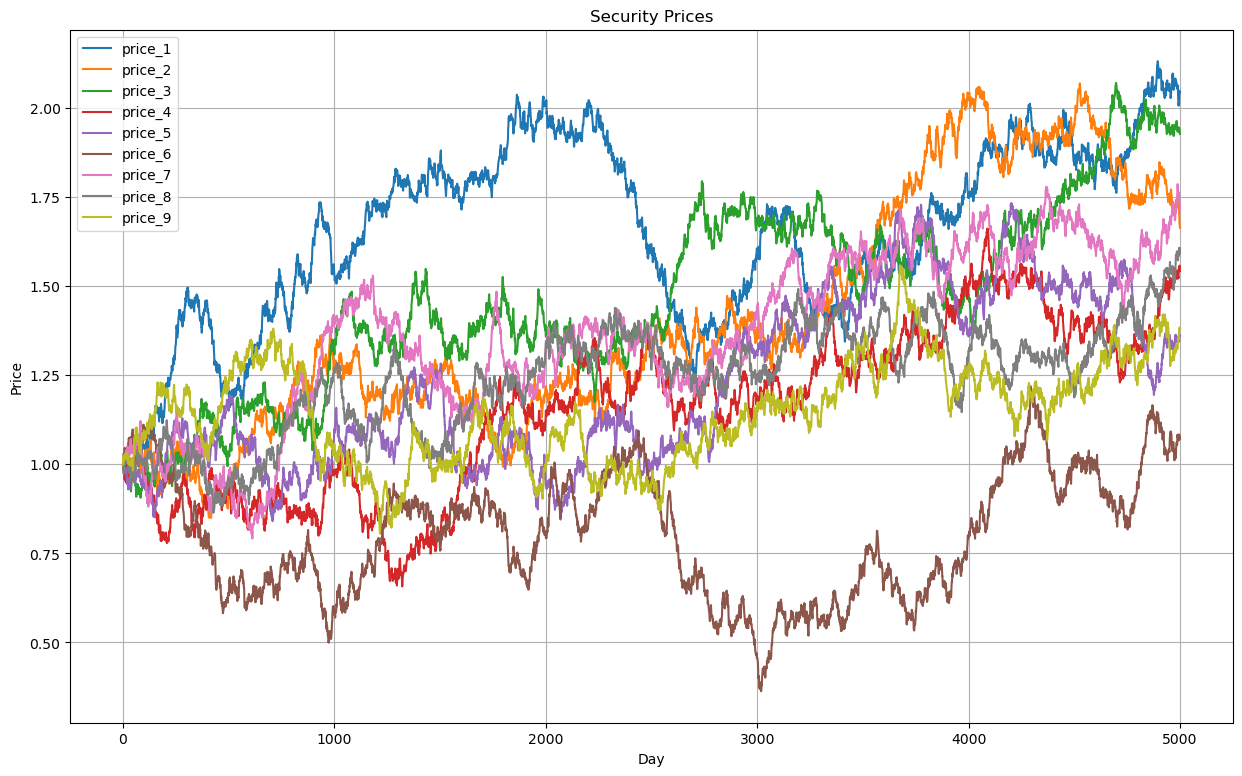

In [73]:
merged_df.plot(figsize=(15,9))
plt.title('Security Prices')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
# Calculate simple moving averages
def calculate_sma(prices, window):
    return prices.rolling(window = window).mean()

In [75]:
# Generate trading signals based on SMA crossover
def generate_signals(prices, short_window, long_window):
    signals = pd.DataFrame(index = prices.index)
    for column in prices.columns:
        signals[f'{column}_short_sma'] = calculate_sma(prices[column], short_window)
        signals[f'{column}_long_sma'] = calculate_sma(prices[column], long_window)
        # 1 if short SMA > long SMA, 0 otherwise
        signals[f'{column}_comparison'] = np.where(signals[f'{column}_short_sma'] > signals[f'{column}_long_sma'], 1, 0)
        # 1 if short SMA flips from < long SMA to > long SMA, -1 if flips from > long SMA to < short SMA
        signals[f'{column}_signal'] = signals[f'{column}_comparison'].diff()
        # Recommend to buy if signal is 1, to sell if signal is -1
        signals[f'{column}_recommendation'] = np.where(signals[f'{column}_signal'] == 1, 'Buy', np.where(signals[f'{column}_signal'] == -1, 'Sell', None))
    return signals

In [76]:
# Filter by rows with signals for viewing
def filtered_signals(signals, index):
    return signals[signals.filter(like = f'{index}_recommendation').isin(['Buy', 'Sell']).any(axis = 1)]

In [77]:
# Backtest trading signals
def backtest(df_with_signal, price_column, signal_column):
    holdings = 0
    entry_price = 0
    returns = []

    for row in df_with_signal.itertuples(index=False):
        # Access price and signal for the current row
        price = getattr(row, price_column)
        signal = getattr(row, signal_column)
        
        # If buy signal + not holding
        if signal == 1 and holdings == 0:
            # Initialize holding at given price
            holdings = 1
            entry_price = price
        # If sell signal + holding
        elif signal == -1 and holdings == 1:
            pnl = price - entry_price
            returns.append(pnl)
            holdings = 0

    # Return cumulative returns
    return sum(returns)


In [78]:
# Define parameters to generate signals
prices = merged_df
short_window = 20
long_window = 50

In [79]:
# Generate trading signals for each security
signals = generate_signals(prices, short_window, long_window)
#signals.dropna(inplace = True)


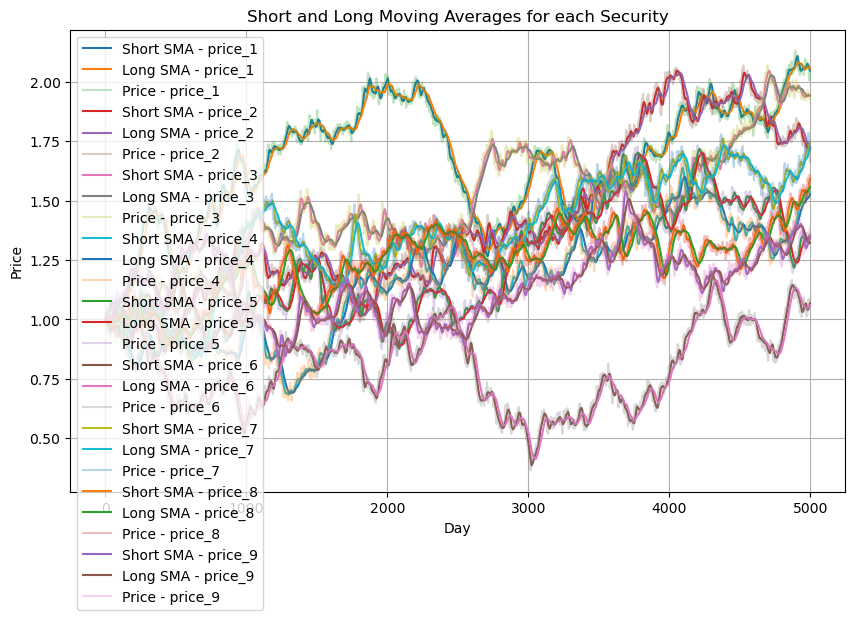

In [80]:
plt.figure(figsize=(10, 6))
for column in merged_df.columns:
    common_index = signals.index.intersection(merged_df.index)  # Find common indices
    plt.plot(common_index, signals.loc[common_index, f'{column}_short_sma'], label=f'Short SMA - {column}')
    plt.plot(common_index, signals.loc[common_index, f'{column}_long_sma'], label=f'Long SMA - {column}')
    plt.plot(common_index, merged_df.loc[common_index, column], label=f'Price - {column}', alpha=0.3)

plt.title('Short and Long Moving Averages for each Security')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
# Filtered signals by security
for i in range(9):
    label = f'price_{i+1}'
    filtered_df = filtered_signals(signals, label)
    columns_to_display = [
        f'price_{i+1}_short_sma',
        f'price_{i+1}_long_sma',
        f'price_{i+1}_recommendation']
    display_df = filtered_df.loc[:, columns_to_display]
    print(f"Filtered Signals for Price {i+1}:")
    display(display_df)

Filtered Signals for Price 1:


,price_1_short_sma,price_1_long_sma,price_1_recommendation
day,,,
60,1.003996,1.002531,Buy
194,1.140622,1.141923,Sell
203,1.153586,1.152295,Buy
333,1.451465,1.452178,Sell
354,1.459779,1.458367,Buy
...,...,...,...
4922,2.076753,2.078577,Sell
4955,2.058230,2.058002,Buy
4956,2.056348,2.056521,Sell


Filtered Signals for Price 2:


,price_2_short_sma,price_2_long_sma,price_2_recommendation
day,,,
53,1.004096,1.003976,Buy
90,1.029755,1.030155,Sell
118,1.021327,1.021189,Buy
144,1.019153,1.019471,Sell
201,0.949684,0.948565,Buy
...,...,...,...
4828,1.743712,1.743887,Sell
4830,1.744168,1.744144,Buy
4838,1.744741,1.744937,Sell


Filtered Signals for Price 3:


,price_3_short_sma,price_3_long_sma,price_3_recommendation
day,,,
98,0.941916,0.940978,Buy
134,0.968733,0.969669,Sell
160,0.967965,0.967921,Buy
194,0.994541,0.996941,Sell
217,1.006116,1.004070,Buy
...,...,...,...
4907,1.975754,1.974793,Buy
4925,1.974929,1.975451,Sell
4928,1.973520,1.973492,Buy


Filtered Signals for Price 4:


,price_4_short_sma,price_4_long_sma,price_4_recommendation
day,,,
50,0.990230,0.979581,Buy
101,1.017861,1.019927,Sell
226,0.802457,0.799843,Buy
312,0.931528,0.931741,Sell
361,0.855243,0.851244,Buy
...,...,...,...
4624,1.390983,1.390385,Buy
4656,1.393386,1.394694,Sell
4748,1.272123,1.269296,Buy


Filtered Signals for Price 5:


,price_5_short_sma,price_5_long_sma,price_5_recommendation
day,,,
50,0.975284,0.972868,Buy
71,0.967051,0.967109,Sell
80,0.971451,0.971291,Buy
82,0.971573,0.971977,Sell
171,0.908175,0.905601,Buy
...,...,...,...
4656,1.441621,1.440750,Buy
4754,1.542423,1.543510,Sell
4897,1.243776,1.240977,Buy


Filtered Signals for Price 6:


,price_6_short_sma,price_6_long_sma,price_6_recommendation
day,,,
50,1.070255,1.045538,Buy
64,1.054018,1.054025,Sell
80,1.062300,1.062296,Buy
148,1.088591,1.090151,Sell
235,0.962132,0.962051,Buy
...,...,...,...
4774,0.856595,0.855180,Buy
4889,1.125846,1.128457,Sell
4960,1.059109,1.056895,Buy


Filtered Signals for Price 7:


,price_7_short_sma,price_7_long_sma,price_7_recommendation
day,,,
50,1.046123,1.034647,Buy
96,1.054646,1.055042,Sell
144,0.937521,0.936203,Buy
188,0.993563,0.995850,Sell
220,0.984115,0.981334,Buy
...,...,...,...
4677,1.580158,1.577552,Buy
4701,1.570381,1.571164,Sell
4753,1.492634,1.492071,Buy


Filtered Signals for Price 8:


,price_8_short_sma,price_8_long_sma,price_8_recommendation
day,,,
68,0.988109,0.987547,Buy
103,1.007349,1.007917,Sell
127,1.011791,1.011152,Buy
147,1.008158,1.009073,Sell
173,1.006588,1.003744,Buy
...,...,...,...
4834,1.395509,1.392715,Buy
4884,1.493390,1.493572,Sell
4920,1.477356,1.477165,Buy


Filtered Signals for Price 9:


,price_9_short_sma,price_9_long_sma,price_9_recommendation
day,,,
55,1.016244,1.015402,Buy
92,1.056214,1.056548,Sell
102,1.071797,1.070965,Buy
208,1.206176,1.206898,Sell
249,1.182583,1.181288,Buy
...,...,...,...
4925,1.392431,1.391768,Buy
4940,1.390661,1.391042,Sell
4941,1.391162,1.390903,Buy


In [82]:
# Signals and prices for backtesting
dfs = {'df1': df1,'df2': df2,'df3': df3,'df4' : df4,'df5' : df5, 'df6' : df6, 'df7': df7, 'df8': df8, 'df9': df9}
dfs_with_signals = {}

for key, df in dfs.items():
    i = key[2:]  
    # Join each security's DataFrame with its corresponding signal column
    df_with_signal = df.join(signals[f'price_{i}_signal'], how='inner')
    dfs_with_signals[key] = df_with_signal

In [83]:
# Results dictionary to store cumulative returns for each security
cumulative_returns = {}

for key, df_with_signal in dfs_with_signals.items():
    price_column = "price"  
    signal_column = f'price_{key[2:]}_signal'  # Construct the signal column name

    # Run backtesting on the df_with_signal
    cumulative_return = backtest(df_with_signal, price_column, signal_column)
    
    # Store the cumulative return in the results dictionary
    cumulative_returns[key] = cumulative_return

    # Print out the result for each security
    print(f"Security {key[2:]} SMA Xover Cumulative Return: {cumulative_return}")

Security 1 SMA Xover Cumulative Return: 1.041535850000001
Security 2 SMA Xover Cumulative Return: 0.1448584959999999
Security 3 SMA Xover Cumulative Return: -0.11236371099999976
Security 4 SMA Xover Cumulative Return: -0.04249846299999949
Security 5 SMA Xover Cumulative Return: 0.7124807719999996
Security 6 SMA Xover Cumulative Return: 0.29089087800000035
Security 7 SMA Xover Cumulative Return: -0.2212555269999994
Security 8 SMA Xover Cumulative Return: 0.46576762699999985
Security 9 SMA Xover Cumulative Return: -0.059691389999999456
